Defined System: M3System(A=3, B=5, C=7, D=11, E=13, modulus=17)

Using seed element: [1, 2, 3]

Generating 1000 pseudorandom numbers...

First 10 generated numbers:
  [1]: [1, 2, 3]
  [2]: [0, 11, 8]
  [3]: [10, 15, 14]
  [4]: [7, 15, 14]
  [5]: [1, 9, 5]
  [6]: [15, 10, 15]
  [7]: [16, 16, 7]
  [8]: [9, 5, 16]
  [9]: [3, 12, 1]
  [10]: [6, 16, 7]
...

Analyzing distribution of generated numbers...

Distribution Statistics (Proportion):
  X0:
    Value  0: 0.0610
    Value  1: 0.0590
    Value  2: 0.0590
    Value  3: 0.0600
    Value  4: 0.0560
    Value  5: 0.0580
    Value  6: 0.0570
    Value  7: 0.0610
    Value  8: 0.0560
    Value  9: 0.0620
    Value 10: 0.0590
    Value 11: 0.0620
    Value 12: 0.0580
    Value 13: 0.0600
    Value 14: 0.0600
    Value 15: 0.0560
    Value 16: 0.0560
--------------------
  X1:
    Value  0: 0.0550
    Value  1: 0.0560
    Value  2: 0.0620
    Value  3: 0.0600
    Value  4: 0.0590
    Value  5: 0.0600
    Value  6: 0.0580
    Value  7: 0.0610
 

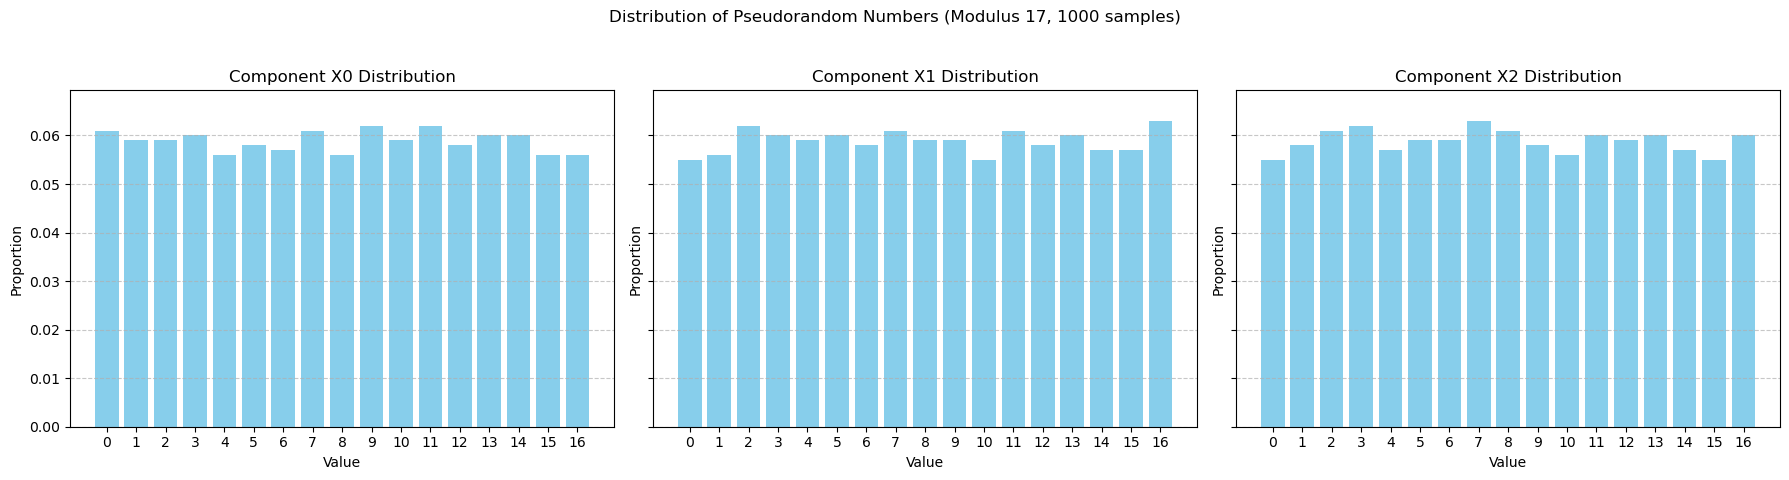


--- End of demonstration ---


In [3]:
import collections.abc
import matplotlib.pyplot as plt
from collections import Counter

# Define the M3System class to hold the parameters and modulus
# This encapsulates the specific algebraic system (V, *)
class M3System:
    def __init__(self, A, B, C, D, E, modulus):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.E = E
        self.modulus = modulus

    # Override __repr__ for better readability of the system object
    def __repr__(self):
        return (f"M3System(A={self.A}, B={self.B}, C={self.C}, D={self.D}, E={self.E}, "
                f"modulus={self.modulus})")

# Define the M3Element class to represent vectors within a specific M3System
class M3Element:
    def __init__(self, value: list[int], system: M3System):
        if not isinstance(value, collections.abc.Sequence) or len(value) != 3:
            raise ValueError("Value must be a list or tuple of 3 integers.")
        if not isinstance(system, M3System):
            raise TypeError("System must be an instance of M3System.")

        self.system = system
        self.value = [x % self.system.modulus for x in value]

    # Standard vector addition for the underlying vector space
    def __add__(self, other):
        if not isinstance(other, M3Element) or self.system != other.system:
            return NotImplemented # Or raise ValueError for system mismatch
        return M3Element([(x + y) % self.system.modulus for x, y in zip(self.value, other.value)], self.system)

    # Standard vector subtraction
    def __sub__(self, other):
        if not isinstance(other, M3Element) or self.system != other.system:
            return NotImplemented
        return M3Element([(x - y) % self.system.modulus for x, y in zip(self.value, other.value)], self.system)

    # Standard unary negation
    def __neg__(self):
        return M3Element([(-x) % self.system.modulus for x in self.value], self.system)

    # The core binary operation '*' as defined in the article
    # Corresponds to (ab) in the article
    def __mul__(self, other):
        if not isinstance(other, M3Element) or self.system != other.system:
            return NotImplemented # Or raise ValueError for system mismatch

        # Components of vector 'a' (self)
        a0, a1, a2 = self.value
        # Components of vector 'b' (other)
        b0, b1, b2 = other.value
        
        # Parameters of the M3System
        A, B, C, D, E = self.system.A, self.system.B, self.system.C, self.system.D, self.system.E
        N = self.system.modulus

        # Component-wise definition of (ab)_i based on the article's K^3 formula
        # (ab)_0 = a_0 + b_0 + a_0 b_0 + A a_1 b_1 + C a_2 b_1 + B a_2 b_2
        r0 = (a0 + b0 + a0 * b0 + A * a1 * b1 + C * a2 * b1 + B * a2 * b2) % N
        
        # (ab)_1 = a_1 + b_1 + a_1 b_0 + a_0 b_1 + D a_1 b_1 + E a_1 b_2
        r1 = (a1 + b1 + a1 * b0 + a0 * b1 + D * a1 * b1 + E * a1 * b2) % N
        
        # (ab)_2 = a_2 + b_2 + a_2 b_0 + a_0 b_2 + D a_2 b_1 + E a_2 b_2
        r2 = (a2 + b2 + a2 * b0 + a0 * b2 + D * a2 * b1 + E * a2 * b2) % N

        return M3Element([r0, r1, r2], self.system)

    # Implements exponentiation a^n (repeated application of '*')
    # Uses exponentiation by squaring for efficiency
    def __pow__(self, exponent: int):
        if not isinstance(exponent, int) or exponent < 0:
            raise ValueError("Exponent must be a non-negative integer.")
        
        # The neutral element 'e' (multiplicative identity) as defined in the article (0,0,0)
        # a * e = e * a = a
        identity_element = M3Element([0, 0, 0], self.system) 

        if exponent == 0:
            return identity_element

        # Start with the base vector 'a'
        base = self 
        # Initialize result with the identity element
        result = identity_element

        # Exponentiation by squaring algorithm
        while exponent > 0:
            if exponent % 2 == 1: # If the current bit of the exponent is 1
                result = result * base # Multiply result by the current base power
            base = base * base         # Square the base
            exponent //= 2             # Integer division by 2 (shift exponent right)

        return result

    # String representation for debugging and printing
    def __repr__(self):
        return f"M3Element(value={self.value}, system_id={id(self.system)})" # Added system_id for clarity

    # User-friendly text representation
    def text(self):
        return str(self.value)

# --- Random Number Generator using M3System ---

def generate_pseudorandom_numbers(m3_system: M3System, seed_element: M3Element, count: int):
    """
    Generates a sequence of pseudorandom numbers using sequential multiplication
    of an M3Element by itself.

    Args:
        m3_system: The M3System instance defining the algebraic structure.
        seed_element: The initial M3Element to start the sequence.
        count: The number of pseudorandom numbers to generate.

    Yields:
        The generated M3Element at each step.
    """
    if not isinstance(m3_system, M3System):
        raise TypeError("m3_system must be an instance of M3System.")
    if not isinstance(seed_element, M3Element):
        raise TypeError("seed_element must be an instance of M3Element.")
    if seed_element.system != m3_system:
        raise ValueError("seed_element must belong to the provided m3_system.")
    if not isinstance(count, int) or count <= 0:
        raise ValueError("count must be a positive integer.")

    current_element = seed_element
    for _ in range(count):
        yield current_element
        current_element = current_element * seed_element # Multiply by the seed element

# --- Statistics and Visualization ---

def analyze_distribution(numbers: list[M3Element]):
    """
    Analyzes the distribution of the generated M3Element values.
    It considers each component (x0, x1, x2) individually.

    Args:
        numbers: A list of M3Element objects.

    Returns:
        A dictionary containing the frequency distribution for each component.
    """
    if not numbers:
        return {"x0": {}, "x1": {}, "x2": {}}

    modulus = numbers[0].system.modulus
    
    # Extract components
    x0_values = [el.value[0] for el in numbers]
    x1_values = [el.value[1] for el in numbers]
    x2_values = [el.value[2] for el in numbers]

    # Calculate frequencies
    x0_counts = Counter(x0_values)
    x1_counts = Counter(x1_values)
    x2_counts = Counter(x2_values)

    # Normalize counts to percentages (optional, but good for comparison)
    total_numbers = len(numbers)
    x0_dist = {k: v / total_numbers for k, v in x0_counts.items()}
    x1_dist = {k: v / total_numbers for k, v in x1_counts.items()}
    x2_dist = {k: v / total_numbers for k, v in x2_counts.items()}

    return {"x0": x0_dist, "x1": x1_dist, "x2": x2_dist}

def plot_distribution(distribution_data: dict, modulus: int, title: str):
    """
    Plots the distribution of the generated numbers for each component.

    Args:
        distribution_data: Dictionary containing 'x0', 'x1', 'x2' distributions.
        modulus: The modulus of the M3System.
        title: Title for the plot.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(title)

    components = ['x0', 'x1', 'x2']
    
    for i, comp in enumerate(components):
        ax = axes[i]
        dist = distribution_data[comp]
        
        # Ensure all possible values from 0 to modulus-1 are present, even if count is 0
        all_possible_values = list(range(modulus))
        counts = [dist.get(val, 0) for val in all_possible_values]

        ax.bar(all_possible_values, counts, width=0.8, color='skyblue')
        ax.set_title(f'Component {comp.upper()} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Proportion')
        ax.set_xticks(all_possible_values)
        ax.set_ylim(0, max(counts) * 1.1 if counts else 1) # Adjust y-limit dynamically
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # 1. Define the specific M3System with its parameters and modulus
    #    These are the fixed parameters for your algebraic structure
    my_system = M3System(A=3, B=5, C=7, D=11, E=13, modulus=17)
    print(f"Defined System: {my_system}\n")

    # 2. Create M3Element instances within this system
    seed = M3Element([1, 2, 3], my_system) # Our chosen seed for the PRNG
    print(f"Using seed element: {seed.text()}\n")

    # 3. Generate pseudorandom numbers
    num_generations = 1000 # Number of pseudorandom numbers to generate
    print(f"Generating {num_generations} pseudorandom numbers...\n")
    
    prn_generator = generate_pseudorandom_numbers(my_system, seed, num_generations)
    generated_numbers = list(prn_generator) # Convert generator to a list for analysis

    print(f"First 10 generated numbers:")
    for i, num_elem in enumerate(generated_numbers[:10]):
        print(f"  [{i+1}]: {num_elem.text()}")
    print("...\n")

    # 4. Build and display statistics of the distribution
    print("Analyzing distribution of generated numbers...\n")
    distribution_results = analyze_distribution(generated_numbers)

    print("Distribution Statistics (Proportion):")
    for component, dist in distribution_results.items():
        print(f"  {component.upper()}:")
        sorted_dist = sorted(dist.items()) # Sort for consistent output
        for val, prop in sorted_dist:
            print(f"    Value {val:2d}: {prop:.4f}")
        print("-" * 20)

    # 5. Plot the distribution
    plot_distribution(distribution_results, my_system.modulus, 
                      f"Distribution of Pseudorandom Numbers (Modulus {my_system.modulus}, {num_generations} samples)")

    print("\n--- End of demonstration ---")